### PARTE NO  ENTRENADA 

1/1 [==============================] - 0s 83ms/step


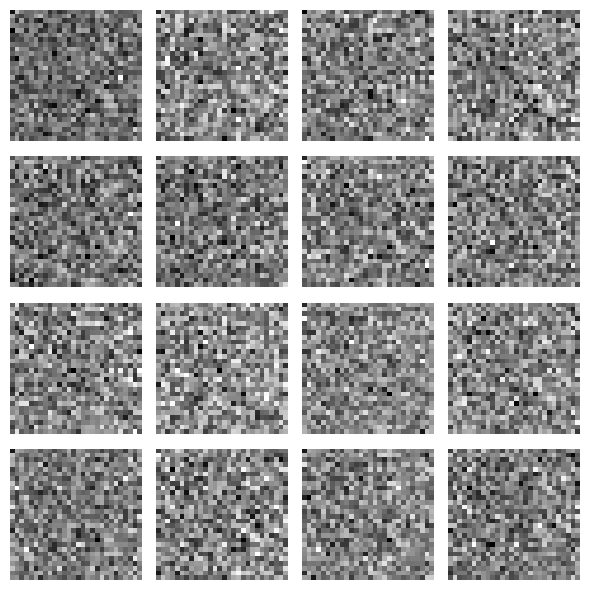

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

class GANBuilder:
    def __init__(self, generator_input_dim=100, discriminator_input_shape=(28, 28, 1)):
        self.generator_input_dim = generator_input_dim
        self.discriminator_input_shape = discriminator_input_shape

    def _create_dense_block(self, units, alpha=0.2, momentum=0.8):
        return [
            Dense(units),
            LeakyReLU(alpha=alpha),
            BatchNormalization(momentum=momentum)
        ]

    def build_generator(self):
        model = Sequential(self._create_dense_block(256) +
                           self._create_dense_block(512) +
                           self._create_dense_block(1024) +
                           [Dense(784, activation='tanh'), Reshape(self.discriminator_input_shape)])
        model.build(input_shape=(None, self.generator_input_dim))
        return model
    
    def build_discriminator(self):
        model = Sequential([Flatten(input_shape=self.discriminator_input_shape)] +
                           self._create_dense_block(1024) +
                           self._create_dense_block(512) +
                           self._create_dense_block(256) +
                           [Dense(1, activation='sigmoid')])
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return model

    def build_gan(self, generator, discriminator):
        discriminator.trainable = False
        gan_input = Input(shape=(self.generator_input_dim,))
        gan_output = discriminator(generator(gan_input))
        gan = Model(gan_input, gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
        return gan


def plot_images(generator, examples=16, dim=(4, 4), figsize=(6, 6)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generated_images = generator.predict(noise).reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
builder = GANBuilder()
generator = builder.build_generator()
discriminator = builder.build_discriminator()
gan = builder.build_gan(generator, discriminator)

plot_images(generator)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Cargar y preprocesar los datos
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.0  # Normalizar a [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Añadir una dimensión para canales

class GAN:
    def __init__(self):
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        self.gan = self._build_gan()

    def _build_generator(self):
        model = Sequential([
            Dense(256, input_dim=100),
            LeakyReLU(0.2),
            BatchNormalization(0.8),
            Dense(512),
            LeakyReLU(0.2),
            BatchNormalization(0.8),
            Dense(1024),
            LeakyReLU(0.2),
            BatchNormalization(0.8),
            Dense(np.prod((28, 28, 1)), activation='tanh'),
            Reshape((28, 28, 1))
        ])
        return model
    
    def _build_discriminator(self):
        model = Sequential([
            Flatten(input_shape=(28, 28, 1)),
            Dense(1024),
            LeakyReLU(0.2),
            Dense(512),
            LeakyReLU(0.2),
            Dense(256),
            LeakyReLU(0.2),
            Dense(1, activation='sigmoid')
        ])
        return model
    
    def _build_gan(self):
        self.discriminator.trainable = False
        z = Input(shape=(100,))
        img = self.generator(z)
        valid = self.discriminator(img)
        model = Model(z, valid)
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
        return model
    
    def train(self, epochs, batch_size):
        half_batch = batch_size // 2
        
        for epoch in range(epochs):
            # Training discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_imgs = X_train[idx]
            fake_imgs = self.generator.predict(np.random.normal(0, 1, (half_batch, 100)))
            d_loss_real = self.discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Training generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            valid_y = np.array([1] * batch_size)
            g_loss = self.gan.train_on_batch(noise, valid_y)
            
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            if epoch % 10 == 0:
                self._plot_images(epoch)

    def _plot_images(self, epoch, examples=16, dim=(4, 4), figsize=(6, 6)):
        noise = np.random.normal(0, 1, (examples, 100))
        generated_images = self.generator.predict(noise).reshape(examples, 28, 28)
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'/mnt/data/gan_generated_image_epoch_{epoch}.png')
        plt.show()

# Crear y entrenar la GAN
gan = GAN()
gan.train(epochs=2, batch_size=100)


TypeError: Expected an int or a list/tuple of ints for the argument 'axis', but received: 0.8